<a href="https://colab.research.google.com/github/institutohumai/cursos-python/blob/master/NLP/1_Introduccion/ejercicios/ejercicios_solucion.ipynb"> <img src='https://colab.research.google.com/assets/colab-badge.svg' /> </a>

## LSA

El **"Análisis Semántico Latente"** es una técnica para cuantificar el contenido y significado de documentos que fue extensamente utilizada desde su origen en la década de 1980. 

El procedimiento es el siguiente:
- Computar dado un corpus de textos una matriz de co-ocurrencias.  
- Aplicar una reducción de dimensionalidad sobre esa matriz.
- Esto nos otorga ***embeddings***, o vectores de palabras, y de documentos, que resumen su significado. Con los mismos podemos operar en el "espacio latente".

**Descargar corpus de textos**

In [1]:
#@title Preparamos Dataset de Medios de LatAm
%%capture
!pip install datasets
import pandas as pd
from datasets import load_dataset

data = pd.DataFrame()
configs = ['ar', 'bo', 'br', 'cl', 'co', 'cr', 'gt', 'hn', 'mx', 'ni', 'pa', 'pe', 'pr', 'py', 'sv', 'uy', 've'] # 'com', 'es'
for c in configs:
  data_ = load_dataset("LeoCordoba/CC-NEWS-ES", c)
  data = data.append(data_['train'].to_pandas())

data = data.drop('id', axis=1).reset_index(drop=True)
# Hacemos "downsampling" tomando maximo n_min para 
# los grupos que tienen > n_min, y todos para los que tienen menos
n_min = 1000
df_grouped = data.groupby("country")
df_grouped.groups.values()
frames_of_groups = [x.sample(n_min) if x.shape[0] > n_min else x for y, x in df_grouped] 
data = pd.concat(frames_of_groups)

In [2]:
# Ejecutar la celda de arriba para preparar los datos
print(data.shape[0])
data.sample(2)

15561


,country,text
776381,gt,"""Con honestidad, responsabilidad y valentía te..."
1861842,uy,La política del gobierno respecto de la dictad...


In [3]:
data.country.value_counts()

ar    1000
bo    1000
uy    1000
py    1000
pr    1000
pe    1000
pa    1000
ni    1000
mx    1000
hn    1000
gt    1000
cr    1000
co    1000
cl    1000
ve    1000
sv     454
br     107
Name: country, dtype: int64

**Buscar los N términos más frecuentes**

(pueden hacerlo con lo que prefieran: Python base, con NLTK, con collections.Counter...)

**Repetir quitando stop words***

In [4]:
!pip install stop_words
import stop_words
# Usamos stop words del español
stop_words = stop_words.get_stop_words('es')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import itertools
import re
from collections import Counter

n = 20
# Extraemos todas las palabras con regex
words = data.text.str.lower().str.findall("[A-zA-ú]+").tolist()
# Unimos listas de palabras
words = list(itertools.chain(*words))
# Descartamos números
words = [w for w in words if not re.match('(\d+)', w) and w not in stop_words]
word_counts = Counter(words)

In [6]:
word_counts.most_common()[:n]

[('años', 7970),
 ('si', 6557),
 ('país', 6107),
 ('ser', 6102),
 ('nacional', 5657),
 ('dos', 5567),
 ('parte', 5283),
 ('año', 5018),
 ('dijo', 4947),
 ('gobierno', 4877),
 ('personas', 4855),
 ('presidente', 4655),
 ('según', 4212),
 ('así', 3974),
 ('además', 3785),
 ('millones', 3753),
 ('vida', 3554),
 ('hace', 3397),
 ('después', 3354),
 ('puede', 3322)]

**Aplicar TF-IDF**:

- Usar la clase de sklearn
- Utilizar hasta 2 ngramas
- Utilizar los parámetros de TF-IDF para descartar tokens que aparezcan "poco" (definirlo con esos parámetros)

**Aplicar clustering sobre los documentos, usando la matriz de TF-IDF.** 

Pueden usar cualquier algorítmo de clustering (KMeans, HDBscan...)

**Visualizar los clusters, en 2D o en 3D**

Con matplotlib, seaborn o plotly

In [7]:
# Vectorizamos el texto con TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt

vectorizer = TfidfVectorizer(max_df=0.5, max_features=10000,
                             min_df=2, stop_words=stop_words)

X = vectorizer.fit_transform(data.text)

print("n_samples: %d, n_features: %d" % X.shape)

n_samples: 15561, n_features: 10000


In [8]:
# Armamos el pipeline porque el TruncatedSVD no devuelve los datos normalizados
# (va a ser importante normalizar para la etapa posterior)
svd = TruncatedSVD(100,random_state = 1) 
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)
X = lsa.fit_transform(X)

In [9]:
# Clusterizamos con KMeans
from sklearn.cluster import KMeans
k = 10
km = KMeans(n_clusters=k, max_iter=100, n_init=10, random_state = 1)
km.fit(X)

KMeans(max_iter=100, n_clusters=10, random_state=1)

In [10]:
# Los centroides están mapeados en el espacio de dimensiones reducidas
# Hacemos la transformación inversa para ver el peso de los features originales (10000 dim)
original_space_centroids = svd.inverse_transform(km.cluster_centers_)

# La función argsort nos da los índices ordenados
order_centroids = original_space_centroids.argsort()[:, ::-1]

# Imprimimos los términos más "pesados" (frecuentes) para cada categoría
# Con los índices ordenados, llamamos a la descripción de las palabras que construyó el Vectorizer()
terms = vectorizer.get_feature_names_out()

print("Ranking de términos por tópico:")

for i in range(k):
    print("Tópico  %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

# Nos quedamos con los 10 índices ordenados más importantes en cada tópico
# Los tópicos parecen tener sentido: Tópico 0(religion), Tópico 1(gráficos) y Tópico 2(espacio)

Ranking de términos por tópico:
Tópico  0: equipo partido final copa dos fútbol club gol liga goles
Tópico  1: policía san dos años zona según lugar personas ciudad autoridades
Tópico  2: si vida ser siempre bien día años gente cosas puede
Tópico  3: venezuela maduro guaidó gobierno presidente nicolás país venezolanos venezolano pueblo
Tópico  4: salud personas desarrollo nacional trabajo proyecto educación parte empresa además
Tópico  5: partido electoral presidente gobierno elecciones nacional ley política si país
Tópico  6: caso fiscalía justicia fiscal tribunal investigación juez años delitos prisión
Tópico  7: música años película the historia mundo parte cine mejor gran
Tópico  8: millones dólares 000 año us mil ciento mercado según años
Tópico  9: gobierno país unidos trump presidente panamá derechos méxico dijo 2019


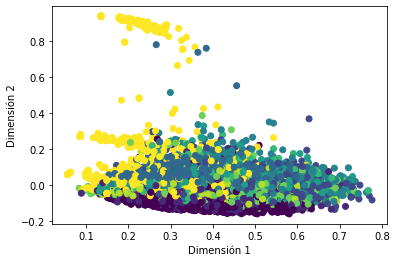

In [11]:
# Visualizamos los clusters en el espacio reducido
plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=km.labels_)
plt.xlabel('Dimensión 1')
plt.ylabel('Dimensión 2')
plt.show()

## Extra:

Ver Social Listening en Twitter en [este Colab](https://github.com/institutohumai/talleres/blob/master/Twitter_Social_Listening_ejemplo.ipynb), que tiene un proceso muy completo de NLP, incluyendo visualización de clusters en 3D y word clouds :) 
